# Tree construction visualization

This notebook shows how to visualize the construction of a tree using what's stored inside the memory of each node.
This in-memory information can be obtained by a tree-building algorithm, or by hand.


In [1]:
# If pydistsim is not installed and the script is run from docs/notebooks directory
# import sys
# sys.path.append("../../")

# for interactive plots
%matplotlib notebook

from pydistsim.network import NetworkGenerator

## Manual assignment of tree edges

First, let's create a tree by hand, and then visualize it.

We will start with a HyperCube of dimension 3, and then select a few edges to make it a tree.


In [2]:
net = NetworkGenerator.generate_hypercube_network(dimension=3, use_binary_labels=False)
TREE_KEY = "TREE"

<IPython.core.display.Javascript object>

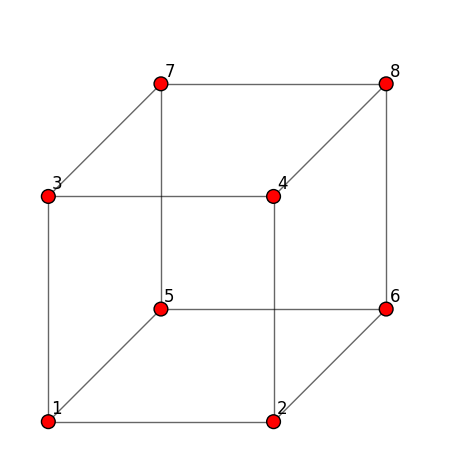

In [3]:
net.show()

Now we add the tree information to each node. In this cell, we will set the `children` reference for some of the nodes.

The key idea is that the tree information is distributed among the nodes, and we can reconstruct the tree by following
the references. But to find such references, we need to know where in the memory they are stored, this is where the
definition of a global `TREE_KEY` is needed.


In [4]:
node = net.node_by_id(8)
node.memory[TREE_KEY] = {
    "children": [net.node_by_id(7), net.node_by_id(4)],
}

node = net.node_by_id(7)
node.memory[TREE_KEY] = {
    "children": [net.node_by_id(3), net.node_by_id(5)],
}

node = net.node_by_id(5)
node.memory[TREE_KEY] = {
    "children": [net.node_by_id(1), net.node_by_id(6)],
}

Now we can visualize the tree by following the references in the memory of each node, but we need the `TREE_KEY` to
know where to look for the references.


<IPython.core.display.Javascript object>

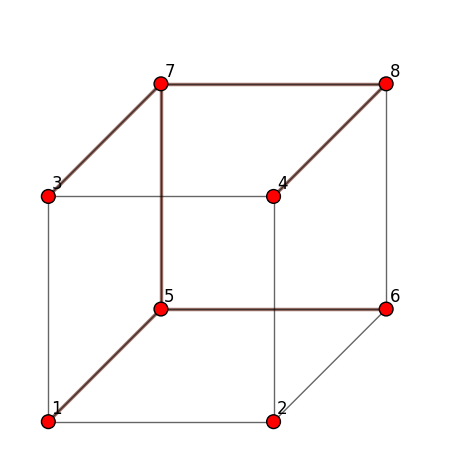

In [5]:
net.show(tree_key=TREE_KEY)

As we can see, node 2 is still missing from the tree. We will add it in the next cell, but using the `parent` reference
instead of the `children` reference.


In [6]:
node = net.node_by_id(2)
node.memory[TREE_KEY] = {
    "parent": net.node_by_id(4),
}


# Alternative tree definition, using children instead of parent:
# node = net.node_by_id(4)
# node.memory[TREE_KEY] = {
#     "children": [net.node_by_id(2)],
# }

<IPython.core.display.Javascript object>

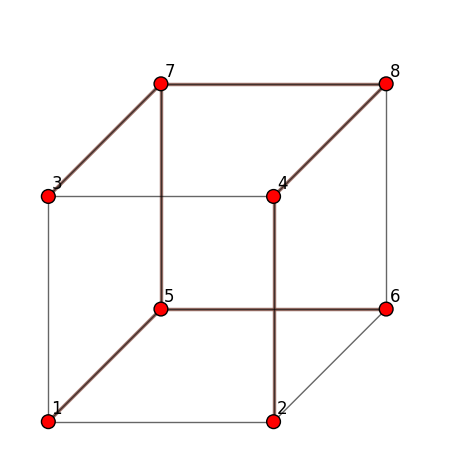

In [7]:
net.show(tree_key=TREE_KEY)

Now the tree is complete.

In the next cell we show how to get a completely new `Network` object from the tree information.


<IPython.core.display.Javascript object>

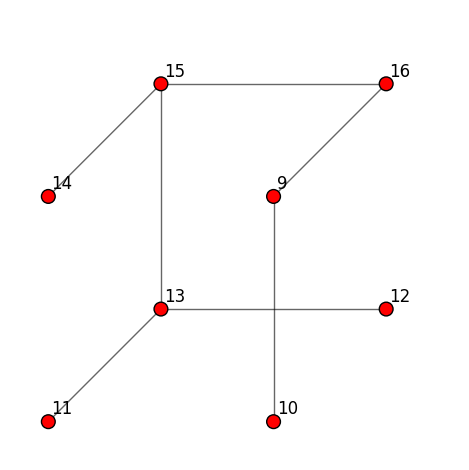

In [8]:
new_net = net.get_tree_net(TREE_KEY)

new_net.show()

## Tree construction algorithm visualization

Now we show how to visualize the construction of a tree from inside an algorithm. We will use the `FloodTree` algorithm,
an extension of the `Flood` algorithm from the `demo_algorithms` module.

Check the module at: https://github.com/agustin-recoba/PyDistSim/tree/main/pydistsim/demo_algorithms

The algorithm is simple: broadcast a message from an initiator and make each node set its parent as the first node
that sent the message to it.


In [9]:
from pydistsim import Simulation
from pydistsim.gui.drawing import create_animation
from pydistsim.network.behavior import ExampleProperties
from pydistsim.algorithm.node_wrapper import NodeAccess
from pydistsim.message import Message
from pydistsim.demo_algorithms.broadcast import Flood


class FloodTree(Flood):
    """
    Simple extension of the Flood algorithm that uses the first received message to determine the parent node.
    """

    # It's required to define where the tree information should be stored
    required_params = ["tree_key"]

    def initializer(self):
        # Do the same as Flood, but also initialize the memory for the tree
        super().initializer()

        for node in self.network.nodes():
            node.memory[self.tree_key] = {}

    @Flood.Status.IDLE
    def receiving(self, node: NodeAccess, message: Message):
        # Do the same as Flood, but also store the parent node
        super().receiving_IDLE(node, message)

        node.memory[self.tree_key]["parent"] = message.source

Now, initialize the simulation and create the network.


In [10]:
net = NetworkGenerator.generate_hypercube_network(16, use_binary_labels=False)


# Let's add some random delays to the communication, so we can see how that affects the tree building
net.behavioral_properties = ExampleProperties.RandomDelayCommunication

# Set the tree_key in which the tree will be stored in the nodes' memory
sim = Simulation(net, ((FloodTree, {"tree_key": TREE_KEY}),))

Just as in the animation tutorial, but now we need to pass the key in which the tree information is stored in the nodes.


In [11]:
anim = create_animation(sim, tree_key=TREE_KEY)
video = anim.to_html5_video()

from IPython.display import HTML

HTML(video)

<IPython.core.display.Javascript object>

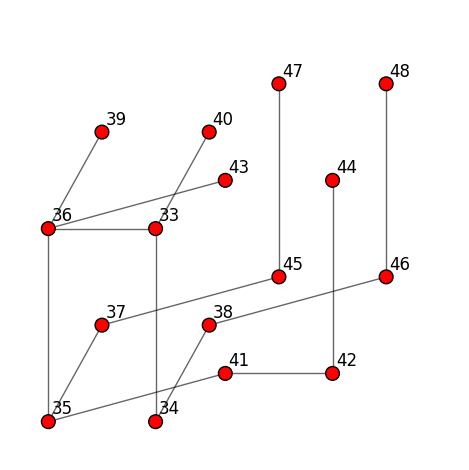

In [12]:
final_tree_net = sim.network.get_tree_net(TREE_KEY)
final_tree_net.show()